In [8]:
!pip install -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import gzip
from IPython.display import display

from json import loads
from tqdm.notebook import tqdm, trange
from typing import Generator, Iterable, Union, TypeVar
from scipy import sparse
from sklearn.model_selection import train_test_split, KFold


tqdm.pandas()

# Data loading

In [10]:
def parse_json(filename: str, read_max: int = None, attributes: Iterable[str] = None) -> pd.DataFrame:
    """
    Reads the file line by line, parsing each line as json.

    :param filename: The path to the datafile.
    :param read_max: The maximum number of lines to read from the datafile.
    :param attributes: The attributes of each JSON object that should be extracted; other attributes are ignored.
    """
    file = gzip.open(filename, "r")
    data = []
    for index, line in enumerate(tqdm(file)):
        if index == read_max:
            break
        entry = loads(line)
        if attributes is not None:
            entry = {key: entry[key] for key in attributes}
        data.append(entry)
    return pd.DataFrame.from_dict(data)

In [11]:
data_path = "data/"
books = f"{data_path}goodreads_books_comics_graphic.json.gz"
interactions = f"{data_path}goodreads_interactions_comics_graphic.json.gz"
reviews = f"{data_path}goodreads_reviews_comics_graphic.json.gz"

n = None

books_df = parse_json(books, n, ("book_id", "title"))
interactions_df = parse_json(interactions, n, ("user_id", "book_id", "rating"))

display(books_df.head(10))
display(interactions_df.head(10))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,book_id,title
0,25742454,The Switchblade Mamma
1,30128855,Cruelle
2,13571772,Captain America: Winter Soldier (The Ultimate ...
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...
4,707611,"Superman Archives, Vol. 2"
5,2250580,"A.I. Revolution, Vol. 1"
6,27036536,"War Stories, Volume 3"
7,27036537,"Crossed, Volume 15"
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)"
9,27036539,"War Stories, Volume 4"


,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,836610,0
1,8842281e1d1347389f2ab93d60773d4d,7648967,0
2,8842281e1d1347389f2ab93d60773d4d,15704307,0
3,8842281e1d1347389f2ab93d60773d4d,6902644,0
4,8842281e1d1347389f2ab93d60773d4d,9844623,0
5,8842281e1d1347389f2ab93d60773d4d,13163846,0
6,8842281e1d1347389f2ab93d60773d4d,1137635,0
7,8842281e1d1347389f2ab93d60773d4d,44735,0
8,8842281e1d1347389f2ab93d60773d4d,472331,0
9,8842281e1d1347389f2ab93d60773d4d,24815,5


In [12]:
# Convert the columns to the correct types
# interactions_df["date_updated"] = pd.to_datetime(interactions_df["date_updated"], format="%a %b %d %H:%M:%S %z %Y")
books_df["book_id"] = books_df["book_id"].astype("int64")
interactions_df["book_id"] = interactions_df["book_id"].astype("int64")

# Sort the interactions by user ID and the timestamp
# interactions_df = interactions_df.sort_values(by=["user_id", "date_updated"], ascending=[True, True])

# Preprocessing

In [13]:
def preprocess(dataframe: pd.DataFrame, min_support: int = 5) -> pd.DataFrame:
    """
    Removes users with fewer than `min_support` interactions, and duplicate user-item pairs (which do not exist in the
    dataset anyway). Items with very few interactions are not removed, unless they have no interactions at all after
    removing infrequent users.
    """
    print(dataframe.shape[0], "initial rows")
    # Drop reconsumption items
    dataframe = dataframe.drop_duplicates(subset=["user_id", "book_id"])
    # Drop users with less than `min_support` interactions
    items_per_user = dataframe.groupby("user_id", as_index=False)["book_id"].size()
    items_per_user = items_per_user.rename({"size": "items_per_user"}, axis="columns")
    dataframe = pd.merge(dataframe, items_per_user, how="left", on=["user_id"])
    dataframe = dataframe[dataframe["items_per_user"] >= min_support]
    # Report and clean up after the preprocessing
    print(dataframe.shape[0], "rows after preprocessing")
    dataframe.drop(columns=["items_per_user"], inplace=True)
    return dataframe


display(interactions_df.head(10))
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
interactions_df = preprocess(interactions_df, min_support=5)
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
display(interactions_df.head(10))

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,836610,0
1,8842281e1d1347389f2ab93d60773d4d,7648967,0
2,8842281e1d1347389f2ab93d60773d4d,15704307,0
3,8842281e1d1347389f2ab93d60773d4d,6902644,0
4,8842281e1d1347389f2ab93d60773d4d,9844623,0
5,8842281e1d1347389f2ab93d60773d4d,13163846,0
6,8842281e1d1347389f2ab93d60773d4d,1137635,0
7,8842281e1d1347389f2ab93d60773d4d,44735,0
8,8842281e1d1347389f2ab93d60773d4d,472331,0
9,8842281e1d1347389f2ab93d60773d4d,24815,5


Number of unique users: 342415
Number of unique items: 89411
7347630 initial rows
6995891 rows after preprocessing
Number of unique users: 148438
Number of unique items: 89276


,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,836610,0
1,8842281e1d1347389f2ab93d60773d4d,7648967,0
2,8842281e1d1347389f2ab93d60773d4d,15704307,0
3,8842281e1d1347389f2ab93d60773d4d,6902644,0
4,8842281e1d1347389f2ab93d60773d4d,9844623,0
5,8842281e1d1347389f2ab93d60773d4d,13163846,0
6,8842281e1d1347389f2ab93d60773d4d,1137635,0
7,8842281e1d1347389f2ab93d60773d4d,44735,0
8,8842281e1d1347389f2ab93d60773d4d,472331,0
9,8842281e1d1347389f2ab93d60773d4d,24815,5


In [14]:
def apply_consecutive_mapping(dataframe: pd.DataFrame, column: str, new_column: str, *additional: pd.DataFrame) -> None:
    """
    Generates a consecutive ID column for the values of an existing column. Also adds this column to additional data
    frames with the exact same mapping of old ID to new (consecutive) ID.
    """
    ids = {}

    def map_to_consecutive_ids(uuid: Union[int, np.int64]) -> int:
        """
        To be used with `pd.Dataframe.apply()` or `pd.Dataframe.progress_apply()`; returns a unique ID per distinct
        value.
        """
        if uuid not in ids:
            ids[uuid] = len(ids)
        return ids[uuid]

    dataframe[new_column] = dataframe[column].progress_apply(map_to_consecutive_ids)
    for frame in additional:
        frame[new_column] = frame[column].progress_apply(lambda old_id: ids.get(old_id, -1))


apply_consecutive_mapping(interactions_df, "user_id", "user_id_int")
apply_consecutive_mapping(interactions_df, "book_id", "book_id_int", books_df)

interactions_df = interactions_df[["user_id_int", "book_id_int", "rating"]]
interactions_df = interactions_df.rename(columns={"user_id_int": "user_id", "book_id_int": "item_id"})

display(books_df.head(10))
display(interactions_df.head(10))

  0%|          | 0/6995891 [00:00<?, ?it/s]

  0%|          | 0/6995891 [00:00<?, ?it/s]

  0%|          | 0/89411 [00:00<?, ?it/s]

,book_id,title,book_id_int
0,25742454,The Switchblade Mamma,89095
1,30128855,Cruelle,51852
2,13571772,Captain America: Winter Soldier (The Ultimate ...,41242
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,88960
4,707611,"Superman Archives, Vol. 2",54601
5,2250580,"A.I. Revolution, Vol. 1",28661
6,27036536,"War Stories, Volume 3",11531
7,27036537,"Crossed, Volume 15",11422
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)",11373
9,27036539,"War Stories, Volume 4",10885


,user_id,item_id,rating
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
5,0,5,0
6,0,6,0
7,0,7,0
8,0,8,0
9,0,9,5


In [15]:
DataType = TypeVar("DataType", pd.DataFrame, sparse.csr_matrix)


def generate_random_split(data: DataType, seed: int = None) -> tuple:
    return train_test_split(data, test_size=0.2, random_state=seed)


def split_k_folds(data: sparse.csr_matrix, nr_folds: int = 5) -> Generator[tuple, None, None]:
    """
    Generates K train-test splits for K-fold cross validation.
    """
    kf = KFold(n_splits=nr_folds)
    yield from kf.split(data)


def create_sparse_matrix(dataframe: pd.DataFrame, shape: tuple = None) -> sparse.csr_matrix:
    return sparse.csr_matrix((dataframe["rating"], (dataframe["user_id"], dataframe["item_id"])), shape=shape,
                             dtype=np.int8)


def convert_sparse_matrix_to_sparse_tensor(X) -> tf.SparseTensor:
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, np.float32(coo.data), coo.shape)

In [16]:
shape = (interactions_df["user_id"].max() + 1, interactions_df["item_id"].max() + 1)
interactions_df["rating"] = interactions_df["rating"].apply(lambda value: value / 5.0)
# interaction_matrix = create_sparse_matrix(interactions_df, shape)
# normalized_matrix = interaction_matrix
# normalized_matrix.data = (interaction_matrix.data / 5.0)

# Restricted Boltzmann Machine

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we
will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is
commonly used in RBM's.

In [17]:
# Input processing: Defining a function to return only the generated hidden states

def hidden_layer(v0_state, W, hb):
    # Probabilities of the hidden units
    h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)

    #Sample h  given x
    return tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))


def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
    return tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))


def gibbs_sampling(v0_state: tf.Tensor, weights: tf.Variable, bias_visible: tf.Variable, bias_hidden: tf.Variable,
                   nr_iterations: int = 1) -> tuple:
    """
    Performs gibbs sampling starting with the given input vector.
    :return: A tuple consisting of (in order):
        - The hidden layer `h0_state`, sampled from the given data vector `v0_state`.
        - The final visible layer `vk_state`.
        - The final hidden layer `hk_state`.
    """
    h0_state = hidden_layer(v0_state, weights, hb)
    vk_state = v0_state
    hk_state = h0_state
    for _ in range(nr_iterations):
        vk_state = reconstructed_output(hk_state, weights, bias_visible)
        hk_state = hidden_layer(vk_state, weights, bias_hidden)
    return h0_state, vk_state, hk_state

In [18]:
def error(v0_state, v1_state):
    """
    Returns the sum of the squared reconstruction errors. This error is computed per batch, and should be accumulated
    per epoch. At the end of the epoch the total RMSE can then be computed from that sum.
    """
    return tf.reduce_sum(tf.reduce_mean(tf.square(v0_state - v1_state), 1))

# Evaluation metrics

In [19]:
def get_k_recommendations(user_input: tf.Tensor, W: tf.Tensor, hb: tf.Tensor, vb: tf.Tensor,
                          k: int) -> sparse.csr_matrix:
    user_input = tf.convert_to_tensor(user_input, "float32")
    hh0 = tf.nn.sigmoid(tf.matmul(user_input, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    recommendations = np.argpartition(-vv1, k, 1)[:, :k]
    return recommendations


def array_to_sparse_matrix(recommendations: np.ndarray) -> sparse.csr_matrix:
    user_ids = np.repeat(np.arange(shape[0]), recommendations.shape[1])
    item_ids = recommendations.flatten()
    scores = np.ones(shape[0] * recommendations.shape[1])
    return sparse.csr_matrix((scores, (user_ids, item_ids)), shape=shape)

In [20]:
def sparse_invert_nonzero(a: sparse.csr_matrix) -> sparse.csr_matrix:
    inverse = a.copy()
    inverse.data = 1 / inverse.data
    return inverse


def sparse_divide_nonzero(a: sparse.csr_matrix, b: sparse.csr_matrix) -> sparse.csr_matrix:
    return a.multiply(sparse_invert_nonzero(b))


def compute_recall(true: sparse.csr_matrix, predicted: sparse.csr_matrix) -> float:
    scores = sparse.lil_matrix(predicted.shape)
    scores[predicted.multiply(true).astype(bool)] = 1
    scores = sparse_divide_nonzero(scores.tocsr(), sparse.csr_matrix(true.sum(axis=1))).sum(axis=1)
    return scores.mean()

In [21]:
def get_ndcg(top_k: np.ndarray, actual_scores: np.ndarray):
    numerator = actual_scores[top_k]
    denom = np.log2(np.arange(2, len(top_k) + 2))
    # Calculate DCG and IDCG
    dcg = np.divide(numerator, denom).sum()
    if dcg == 0:
        return 0
    # Sort the scores based on relevance
    ideal_numerator = np.sort(numerator)[::-1]
    idcg = np.divide(ideal_numerator, denom).sum()
    ndcg = dcg / idcg
    return ndcg

# Training the RBM

In [26]:
def train_rbm(train: tf.data.Dataset, validation: tf.data.Dataset, weights: tf.Variable, vb: tf.Variable,
              hb: tf.Variable, cond_weights: tf.Variable) -> tuple:
    """
    The training loop of the (conditional) RBM.

    :param train: The training dataset.
    :param validation: The validation dataset.
    :param weights: The weights of the RBM.
    :param vb: The biases of the visible layer of the RBM.
    :param hb: The biases of the hidden layer of the RBM.
    :param cond_weights: The interaction vector weights of the conditional RBM.

    :return: A tuple containing the final weights, biases, training errors (RMSE), and validation errors.
    """
    train_errors = []
    validation_errors = []

    for _ in trange(epochs, leave=False):
        train_errors.append(0)
        train_iter = iter(train)
        for _ in trange(len(train), leave=False):
            batch = next(train_iter)
            v0_state = tf.sparse.to_dense(batch)
            h0_state, vk_state, hk_state = gibbs_sampling(v0_state, weights, vb, hb, gibbs_sampling_iterations)

            temp_0 = tf.matmul(tf.transpose(v0_state), tf.squeeze(h0_state))
            temp_k = tf.matmul(tf.transpose(vk_state), tf.squeeze(hk_state))
            delta = (temp_0 - temp_k) / v0_state.shape[0]

            sparse_r = sparse.coo_matrix((np.ones(len(batch.indices)), batch.indices.numpy().T), shape=batch.shape)
            r = tf.constant(sparse_r.toarray(), tf.float32)

            weights = weights + alpha * delta
            vb = vb + alpha * tf.reduce_mean(v0_state - vk_state, 0)
            hb = hb + alpha * tf.reduce_mean(tf.squeeze(h0_state - hk_state), 0)
            cond_weights = cond_weights + alpha * tf.matmul(tf.transpose(tf.squeeze(h0_state - hk_state)), r)

            train_errors[-1] += error(v0_state, vk_state)

        validation_errors.append(0)
        validation_iter = iter(validation)
        for _ in trange(len(validation), leave=False):
            v0_state = tf.sparse.to_dense(next(validation_iter))
            _, vk_state, _ = gibbs_sampling(v0_state, weights, vb, hb, 1)
            validation_errors[-1] += error(v0_state, vk_state)

        train_errors[-1] = (train_errors[-1] / len(train)) ** 0.5
        validation_errors[-1] = (validation_errors[-1] / len(validation)) ** 0.5
        # print(f"Epoch {epoch + 1:3}:  {train_errors[-1]:10.5}  ;  {validation_errors[-1]:10.5}")

    return weights, cond_weights, vb, hb, train_errors, validation_errors

In [27]:
def plot_errors(train_errors: list, validation_errors: list, file_name: str = None) -> None:
    plt.plot(range(1, epochs + 1), train_errors, label="Train")
    plt.plot(range(1, epochs + 1), validation_errors, label="Validation")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend()
    if file_name is not None:
        plt.savefig("rmse.png")
    plt.show()

# Experiment

In [30]:
# Training hyperparameters
epochs = 20
batch_size = 250
gibbs_sampling_iterations = 1
nr_recommendations = 10
alpha = 0.01  # Learning rate

hiddenUnits = 20
visibleUnits = shape[1]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

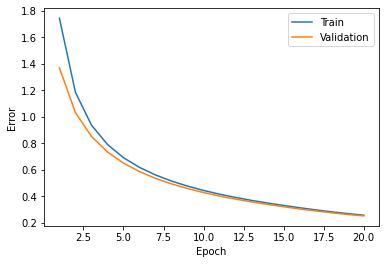

Recall @ 10 = 0.038180103988312175


In [31]:
W, vb, hb = None, None, None

for seed in trange(1, 6, leave=False):
    # train, test = generate_random_split(normalized_matrix, seed=seed)
    train_df, test_df = generate_random_split(interactions_df, seed=seed)
    train = create_sparse_matrix(train_df, shape)
    test = create_sparse_matrix(test_df, shape)

    mean_train_errors = [0] * epochs
    mean_validation_errors = [0] * epochs

    for train_indices, validation_indices in split_k_folds(train):
        tensor_train = convert_sparse_matrix_to_sparse_tensor(train[train_indices])
        tensor_validation = convert_sparse_matrix_to_sparse_tensor(train[validation_indices])

        train_ds = tf.data.Dataset.from_tensor_slices(tensor_train).batch(batch_size)
        validation_ds = tf.data.Dataset.from_tensor_slices(tensor_validation).batch(batch_size)

        W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)
        D = tf.Variable(tf.zeros([visibleUnits]), tf.bool)
        vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32)
        hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32)

        W, D, vb, hb, train_errors, validation_errors = train_rbm(train_ds, validation_ds, W, vb, hb, D)

        for epoch in range(epochs):
            mean_train_errors[epoch] += train_errors[epoch] / 5
            mean_validation_errors[epoch] += validation_errors[epoch] / 5

        break

    plot_errors(mean_train_errors, mean_validation_errors)

    recommendations = np.empty((shape[0], 10), dtype=np.int_)
    for batch_start in range(0, train.shape[0], batch_size):
        batch_end = batch_start + batch_size
        batch = train[batch_start: batch_end]
        recommendations[batch_start: batch_end] = get_k_recommendations(batch.toarray(), W, hb, vb, nr_recommendations)
    recall = compute_recall(test, array_to_sparse_matrix(recommendations))

    print("Recall @", nr_recommendations, "=", recall)

    break